In [28]:
import os

import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import KBinsDiscretizer
import numpy as np
import seaborn as sns
import gpytorch
import torch

from REStats.utils import load_SCADA, filter_outliers
from REStats.plots import save_figs
from REStats.models import calc_iec_power_curve

In [5]:
sns.set_theme()

In [6]:
figs = {}
SAVE_FIGS = True

In [7]:
wt = load_SCADA(2020)

In [8]:
cut_out = 17.5 # TODO: infer?
wt_train = wt[["wind_speed", "power"]]
wt_train = wt_train.resample("H").mean()
wt_train = wt_train[wt_train.wind_speed <= cut_out]

wt_filtered = filter_outliers(wt_train)

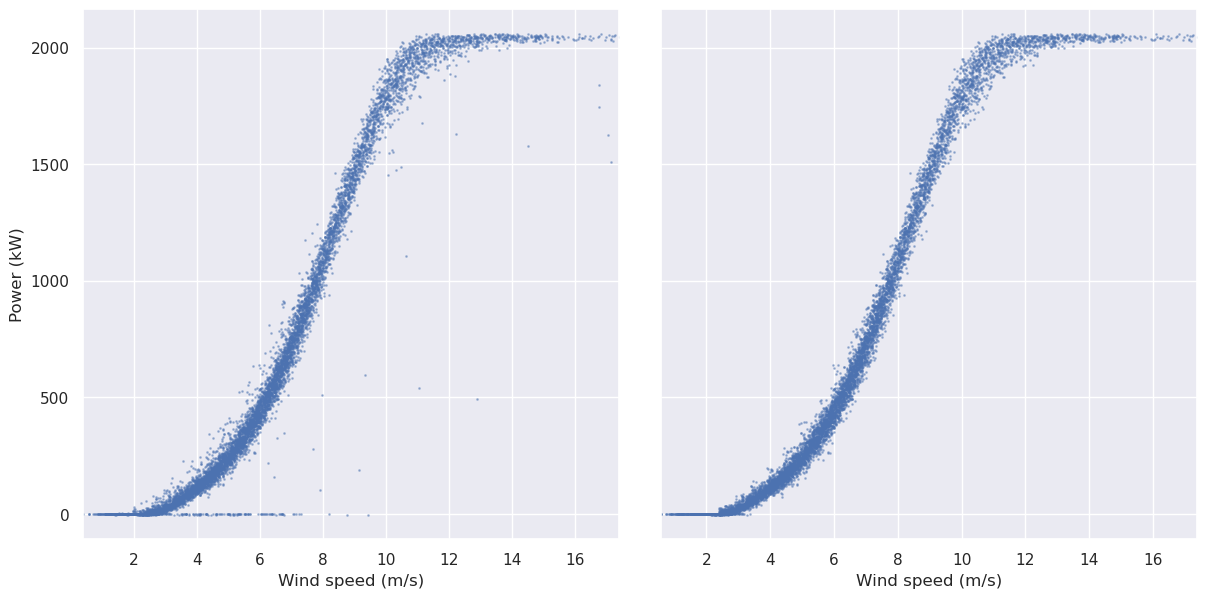

In [9]:
filtered_pc, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
filtered_pc.tight_layout()
axes[0].set_ylabel("Power (kW)")
for ax in axes:
    ax.set_xmargin(0)
    ax.set_xlabel("Wind speed (m/s)")

axes[0].scatter(wt_train.wind_speed, wt_train.power, s=1, alpha=0.4)
axes[1].scatter(wt_filtered.wind_speed, wt_filtered.power, s=1, alpha=0.4)

figs["filtered_pc"] = filtered_pc

In [10]:
iec_pc = calc_iec_power_curve(wt_filtered, cut_out)
iec_pc.tail()

,wind_speed,power
wind_speed,,
"(14.5, 15.0]",14.761471,2044.158234
"(15.0, 15.5]",15.206849,2042.771261
"(15.5, 16.0]",15.750089,2040.320594
"(16.0, 16.5]",16.227438,2042.865202
"(16.5, 17.0]",16.750873,2043.011841


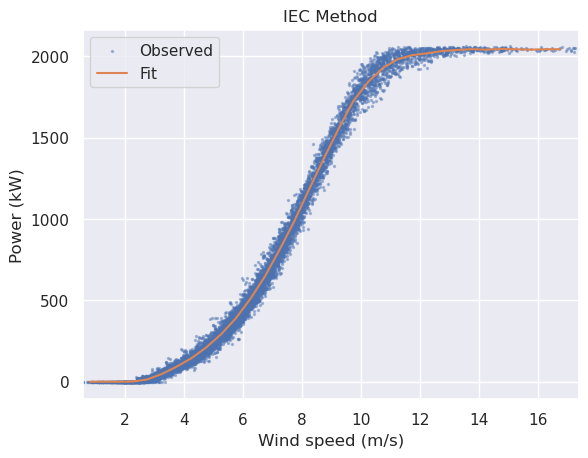

In [11]:
iec_pc_fig, ax = plt.subplots()
ax.set_xmargin(0)
ax.set_xlabel("Wind speed (m/s)")
ax.set_ylabel("Power (kW)")
ax.set_title("IEC Method")

ax.scatter(wt_filtered.wind_speed, wt_filtered.power, s=2, alpha=.4, color="C0", label="Observed")
ax.plot(iec_pc.wind_speed, iec_pc.power, color="C1", label="Fit")

ax.legend()

figs["iec_pc"] = iec_pc_fig

In [12]:
kbd = KBinsDiscretizer(n_bins=20, encode="ordinal")
bins = kbd.fit_transform(wt_filtered.wind_speed.to_numpy()[:, None])

train, test = train_test_split(wt_filtered, stratify=bins, train_size=200, test_size=200, random_state=1)

train["power_std"] = (train.power - train.power.mean())/train.power.std()

train

,wind_speed,power,power_std
Date,,,
2020-05-28 13:00:00,3.025152,25.044428,-1.071966
2020-06-01 07:00:00,3.467658,74.144950,-0.997902
2020-07-04 15:00:00,9.516370,1547.686421,1.224827
2020-04-10 05:00:00,4.795901,240.803740,-0.746509
2020-07-29 18:00:00,3.203873,26.300924,-1.070071
...,...,...,...
2020-09-19 21:00:00,7.919137,1045.547006,0.467386
2020-10-29 20:00:00,12.074335,2014.138906,1.928436
2020-10-02 15:00:00,11.470487,2004.844130,1.914415


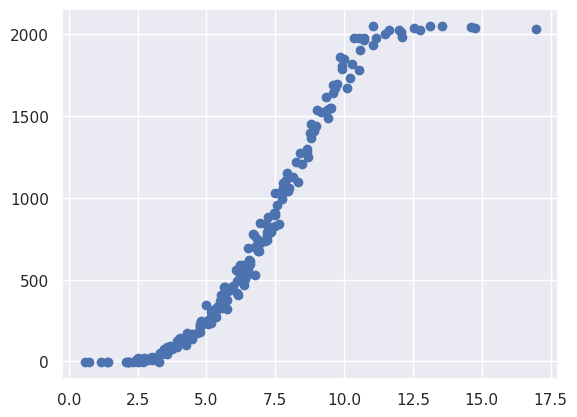

In [13]:
plt.scatter(train.wind_speed, train.power)

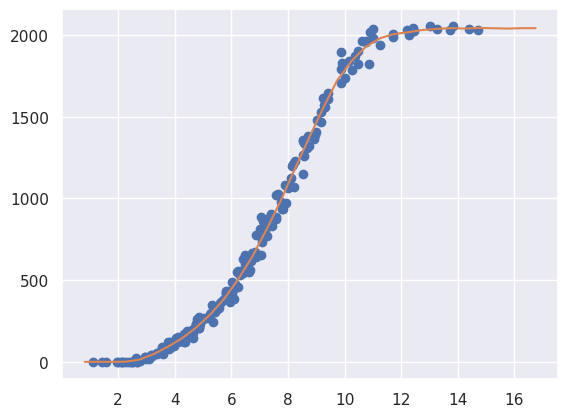

In [14]:
iec_pred = [iec_pc.loc[ws, "power"] for ws in test.wind_speed]

ws_sort = np.argsort(train.wind_speed.values)

fig, ax = plt.subplots()

ax.scatter(test.wind_speed, test.power, color="C0")
ax.plot(iec_pc.wind_speed, iec_pc.power, color="C1")

In [15]:
rmse = mean_squared_error(iec_pred, test.power, squared=False)

print("IEC Test RMSE:", rmse)

IEC Test RMSE: 53.99310683757668


In [16]:
X_prior = np.linspace(0, 18, 500)[:, None]

with pm.Model() as model_prior:                    
    ℓ = pm.Gamma("ℓ", 4, 1)
    η = pm.HalfCauchy("η", 1.5)
    cov_func = η**2 * pm.gp.cov.ExpQuad(1, ls=ℓ)
    
    gp = pm.gp.Latent(cov_func=cov_func)
        
    sigma = pm.HalfNormal("sigma", 1)
    
    f = gp.prior("f", X=X_prior)
    
    idata_pc_prior = pm.sample_prior_predictive(samples=10, random_seed=1)

Sampling: [f_rotated_, sigma, η, ℓ]


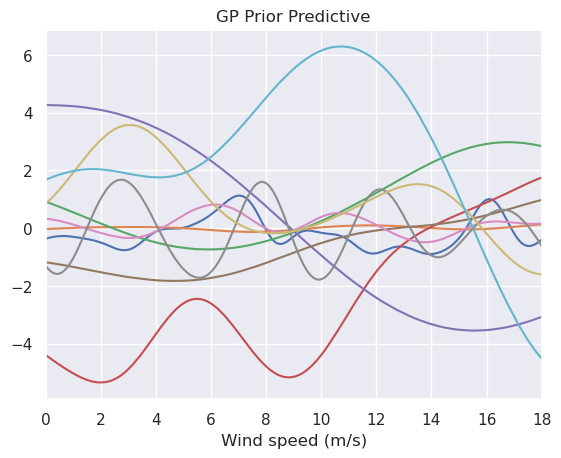

In [17]:
gp_prior, ax = plt.subplots()
ax.set_xmargin(0)
ax.set_title("GP Prior Predictive")
ax.set_xlabel("Wind speed (m/s)")

gp_ppc = idata_pc_prior.prior.f.mean(["chain"])

for gp_y in gp_ppc:
    ax.plot(X_prior, gp_y)
    
figs["gp_prior"] = gp_prior

## `gpytorch`

In [128]:
X_train = torch.tensor(X)
y_train = torch.tensor(y)

# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X_train, y_train, likelihood)

In [129]:
training_iter = 100

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(X_train)
    # Calc loss and backprop gradients
    loss = -mll(output, y_train)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/100 - Loss: 0.890   lengthscale: 0.693   noise: 0.693
Iter 2/100 - Loss: 0.848   lengthscale: 0.744   noise: 0.644
Iter 3/100 - Loss: 0.806   lengthscale: 0.798   noise: 0.598
Iter 4/100 - Loss: 0.765   lengthscale: 0.854   noise: 0.554
Iter 5/100 - Loss: 0.723   lengthscale: 0.912   noise: 0.513
Iter 6/100 - Loss: 0.681   lengthscale: 0.973   noise: 0.474
Iter 7/100 - Loss: 0.639   lengthscale: 1.035   noise: 0.437
Iter 8/100 - Loss: 0.596   lengthscale: 1.100   noise: 0.402
Iter 9/100 - Loss: 0.553   lengthscale: 1.166   noise: 0.370
Iter 10/100 - Loss: 0.509   lengthscale: 1.233   noise: 0.340
Iter 11/100 - Loss: 0.465   lengthscale: 1.303   noise: 0.312
Iter 12/100 - Loss: 0.420   lengthscale: 1.373   noise: 0.285
Iter 13/100 - Loss: 0.375   lengthscale: 1.444   noise: 0.261
Iter 14/100 - Loss: 0.330   lengthscale: 1.517   noise: 0.238
Iter 15/100 - Loss: 0.284   lengthscale: 1.590   noise: 0.217
Iter 16/100 - Loss: 0.238   lengthscale: 1.664   noise: 0.198
Iter 17/100 - Los

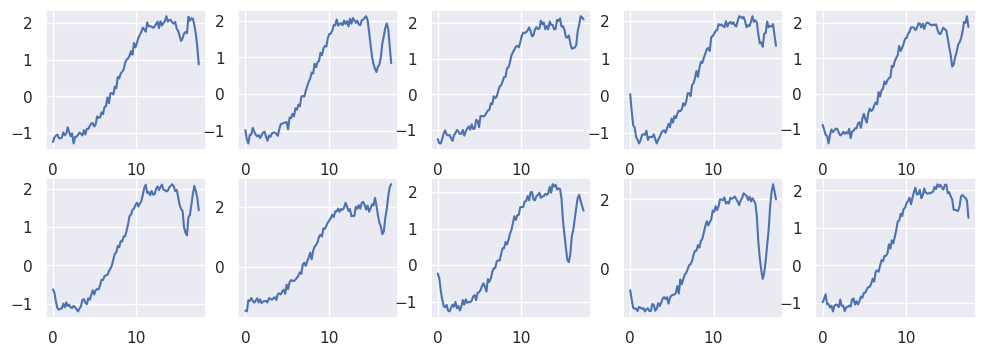

In [130]:
# Define a function to generate prior predictive samples
def prior_predictive(model, likelihood, num_samples):
    model.eval()
    likelihood.eval()
    with gpytorch.settings.fast_pred_var(), torch.no_grad():
        samples = likelihood(model(torch.linspace(0, cut_out, 100))).sample(torch.Size([num_samples]))
    return samples.numpy()

# Generate 10 prior predictive samples
samples = prior_predictive(ExactGPModel(X_train, y_train, likelihood), likelihood, 10)

# Plot the prior predictive samples
fig, axs = plt.subplots(2, 5, figsize=(12, 4))
for i, ax in enumerate(axs.flatten()):
    ax.plot(torch.linspace(0, cut_out, 100), samples[i])
plt.show()

In [131]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    fit_x = torch.linspace(0, cut_out+1.6, 200)
    fit_pred = likelihood(model(fit_x))

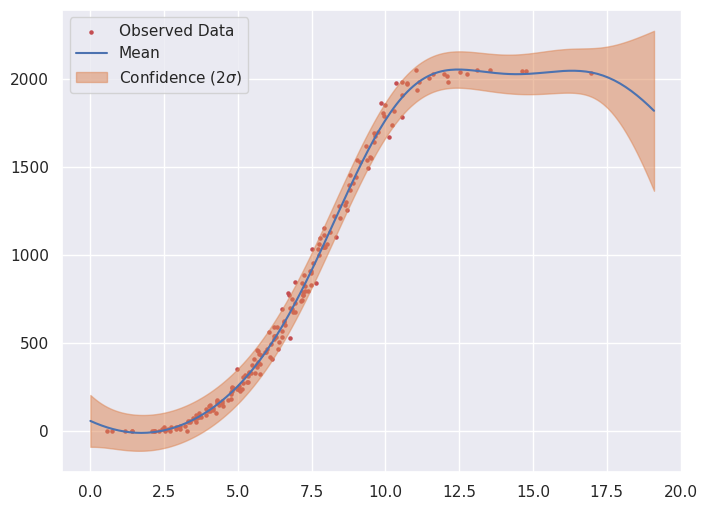

In [132]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(8, 6))

    # Get upper and lower confidence bounds
    lower, upper = fit_pred.confidence_region()
    # Plot training data as black stars
    ax.scatter(train.wind_speed, train.power, s=5, color="C3")
    # Plot predictive means as blue line
    ax.plot(fit_x.numpy(), fit_pred.mean.numpy() * train.power.std() + train.power.mean(), color="C0")
    # Shade between the lower and upper confidence bounds
    lower_tf = lower.numpy() * train.power.std() + train.power.mean()
    upper_tf = upper.numpy() * train.power.std() + train.power.mean()
    ax.fill_between(fit_x.numpy(), lower_tf, upper_tf, color="C1", alpha=0.5)
    ax.legend(['Observed Data', 'Mean', 'Confidence (2$\sigma$)'])

In [133]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    X_test_torch = torch.tensor(X_test)
    test_pred = likelihood(model(X_test_torch))

In [134]:
test_pred_tf = test_pred.mean.numpy() * train.power.std() + train.power.mean()
test_rmse = mean_squared_error(test_pred_tf, test_sort.power, squared=False)

test_rmse

42.603603759018085

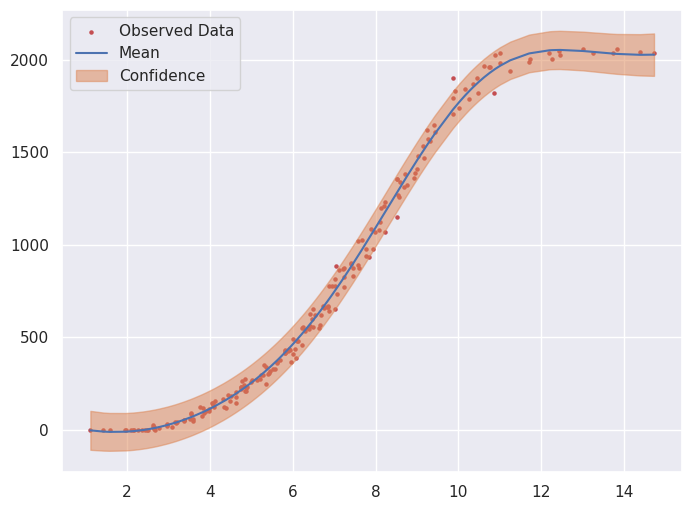

In [135]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(8, 6))

    # Get upper and lower confidence bounds
    lower, upper = test_pred.confidence_region()
    # Plot training data as black stars
    ax.scatter(test.wind_speed, test.power, s=5, color="C3")
    # Plot predictive means as blue line
    ax.plot(X_test_torch.numpy(), test_pred_tf, color="C0")
    # Shade between the lower and upper confidence bounds
    lower_tf = lower.numpy() * train.power.std() + train.power.mean()
    upper_tf = upper.numpy() * train.power.std() + train.power.mean()
    ax.fill_between(X_test_torch.numpy().flatten(), lower_tf, upper_tf, color="C1", alpha=0.5)
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

In [ ]:
if SAVE_FIGS:
    save_figs(figs)